In [1]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from tqdm.notebook import tqdm
try:
    plt.style.use('rossidata')
except:
    pass
from sklearn.model_selection import KFold,train_test_split,LeaveOneOut
import ruptures as rpt
import pymc3 as pm
import matplotlib.patches as mpatches
from datetime import timedelta


In [2]:
#colors=sns.color_palette("husl", 3)

color_set=['#9DD9E5','#E98EBB','#8992C4']

# Baysian Point Change with rescuetime data

Before we get into employing uncertainty quantification on some time series data, we need to prep our data. Here I used the [rescue time API](https://www.rescuetime.com/apidoc) to pull the stats of how much time I spend programming every day

In [3]:
rescue_time_data=pd.read_csv('../data/rescuetime_data.csv')
rescue_time_data['Date']=pd.to_datetime(rescue_time_data['Date'])
rescue_time_data=rescue_time_data.set_index('Date')

For the purposes of this analysis we're going to look at a two month winndow between 

# Plotting Raw Data

Ruptures Change detected at : 2020-10-02 00:00:00


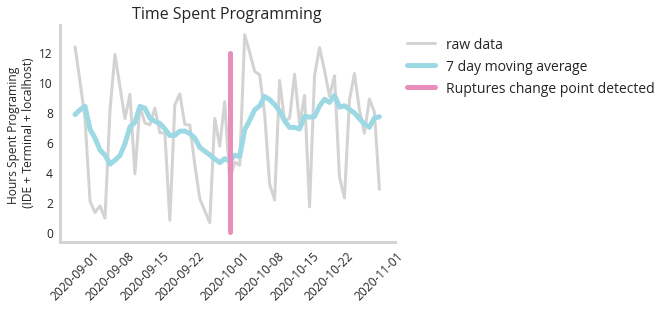

In [5]:
cutoff='2020-09-01'


rolled=rescue_time_data.rolling('7d').mean()
rolled=rolled[cutoff:]
fig,ax=plt.subplots()
ax.plot(rescue_time_data.Hours[cutoff:],color='#d3d3d3',label='raw data',linewidth=3)


ax.plot(rolled.Hours,color=color_set[0],label='7 day moving average',linewidth=5)

rolled=rescue_time_data.rolling('30d').mean()
rolled=rolled[cutoff:]



# ax.plot(rolled.Hours,color=color_set[1],label='1 month moving average',linewidth=3)
ax.set_title('Time Spent Programming')
ax.set_ylabel('Hours Spent Programing \n (IDE + Terminal + localhost)')


mv_date=pd.to_datetime('2020-10-05 00:00:00')        
# ax.plot([mv_date,mv_date],[0,12],color=color_set[1],label='Actual move in date',linewidth=5)

algo = rpt.Pelt(model="l2",min_size=14).fit(rescue_time_data.Hours[cutoff:].values)
result = algo.predict(pen=10)
for r in result:
    if r!=len(rescue_time_data[cutoff:]):
        point=rolled.reset_index().iloc[r].Date
        ax.plot([point,point],[0,12],color=color_set[1],label='Ruptures change point detected',linewidth=5)
        print(f'Ruptures Change detected at : {point}')
        


plt.xticks(rotation='45')
ax.legend(bbox_to_anchor=(1, 1))
fig.savefig('figures/raw_TS_rupture.png',bbox_inches='tight',dpi=300)
fig.savefig('figures/raw_TS_rupture.svg')

# Determining Probabalistic Changes

In [10]:
# map datetime to simple value 
rescue_time_data['order_val']=np.arange(len(rescue_time_data))


In [61]:
def log_function(x,x0,k,A,L):
    return (L)/(1+np.exp(-k*(x-x0)))+A


mod = pm.Model()
with mod as logistic_model:
    # Priors for unknown model parameters
    x0 = pm.Uniform('x0', min(rescue_time_data['order_val']), max(rescue_time_data['order_val']))    
    k = pm.Normal('k', mu=0,sd=1)
    L = pm.Normal('L',mu=2,sd=1)
    A = pm.Normal('A',mu=6,sd=1)
    
    # Expected value of outcome
    x=rescue_time_data['order_val'].values
    mu=log_function(x,x0,k,A,L)

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=mu, observed = rescue_time_data['Hours'].values)

    map_estimate = pm.find_MAP()
    sampler=pm.Metropolis()
    # draw 10000 posterior samples

    trace = pm.sample(10000,tune=5000,step=sampler, start=map_estimate)

logp = -525.57, ||grad|| = 32.233: 100%|██████████| 79/79 [00:00<00:00, 2402.44it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [A]
>Metropolis: [L]
>Metropolis: [k]
>Metropolis: [x0]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:07<00:00, 8105.63draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [62]:
parameter_df = pd.DataFrame({
  'x0': trace['x0'],
    'k': trace['k'], 
    'L': trace['L'], 
    'A': trace['A'],
})

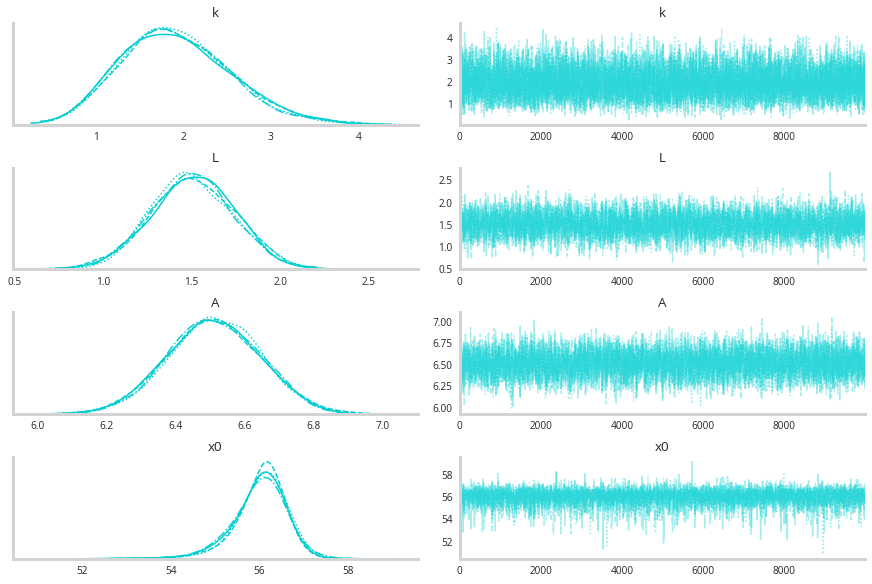

In [63]:
### Generic plots from pymc3
pm.traceplot(trace);
#pm.plot_posterior(trace)

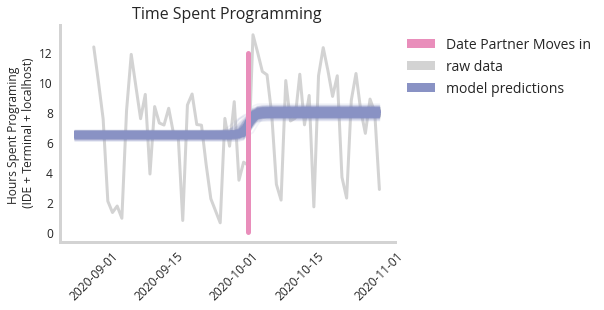

In [72]:

fig,ax=plt.subplots()

ax.plot(rescue_time_data.Hours[cutoff:],color='#d3d3d3',linewidth=3)


x=rescue_time_data['order_val'].values[20:]
for idx,row in parameter_df[::100].iterrows():
    mu=log_function(x,row['x0'],row['k'],row['A'],row['L'])
    ax.plot(rescue_time_data.index[20:],mu, color=color_set[2], alpha=0.1)

mv_date=pd.to_datetime('2020-10-04 00:00:00')        
ax.plot([mv_date,mv_date],[0,12],color=color_set[1],label='Actual move in date',linewidth=5)

ax.set_title('Time Spent Programming')
ax.set_ylabel('Hours Spent Programing \n (IDE + Terminal + localhost)')

colors=[color_set[1],'#d3d3d3',color_set[2]]
texts=['Date Partner Moves in','raw data','model predictions']
recs=[]
rec_labels=[]
for c, text in enumerate(texts):
    rec_labels.append(text)
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors[c]))
ax.legend(recs, rec_labels,bbox_to_anchor=(1, 1))

plt.xticks(rotation='45')

fig.savefig('figures/programming_model_fit.png',bbox_inches='tight',dpi=300)
fig.savefig('figures/programming_model_fit.svg')

# Taking a look at the posterior distributions


In [65]:
basetime=rescue_time_data.head(1).index[0]
parameter_df['x0_datetime']=parameter_df.x0.apply(lambda x:basetime+timedelta(days=x))

/Users/nicholas.rossi/Library/Python/3.7/lib/python/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nicholas.rossi/Library/Python/3.7/lib/python/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


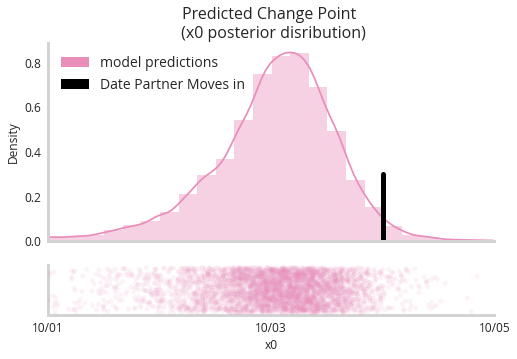

In [73]:
fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [4, 1]},sharex=True,figsize=(8,5))
ax[0].set_title('Predicted Change Point \n (x0 posterior disribution)')
sns.distplot(parameter_df['x0'],ax=ax[0],color=color_set[1])
sns.stripplot(parameter_df['x0'][::10],ax=ax[1],alpha=0.1,color=color_set[1])
ax[0].plot([57,57],[0,.3],color='black',linewidth=5)
ax[0].set_xlim([54,58])
xticks=[54,56,58]
ax[1].set_xticks(xticks)

ax[1].set_xticklabels([(basetime+timedelta(days=x)).strftime("%m/%d") for x in xticks])


ax[0].set_xticks(xticks)

ax[0].set_xticklabels([(basetime+timedelta(days=x)).strftime("%m/%d") for x in xticks])


colors=[color_set[1],'black']
texts=['model predictions','Date Partner Moves in']
recs=[]
rec_labels=[]
for c, text in enumerate(texts):
    rec_labels.append(text)
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors[c]))
ax[0].legend(recs, rec_labels)

fig.savefig('figures/x0_posterior.png',bbox_inches='tight',dpi=300)
fig.savefig('figures/x0_posterior.svg')

/Users/nicholas.rossi/Library/Python/3.7/lib/python/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nicholas.rossi/Library/Python/3.7/lib/python/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


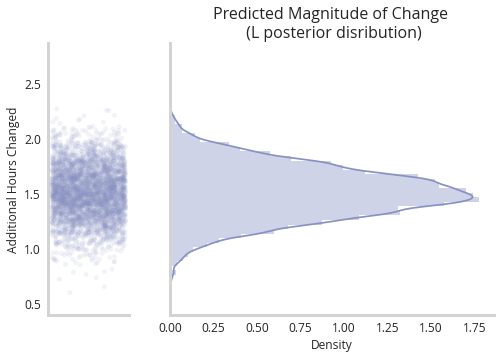

In [69]:
fig,ax=plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]},sharey=True,figsize=(8,5))
sns.stripplot(y='L',data=parameter_df[::10],ax=ax[0],color=color_set[2],alpha=0.1)
sns.distplot(parameter_df['L'],ax=ax[1],vertical=True,color=color_set[2])
ax[0].set_ylabel('Additional Hours Changed')
ax[1].set_title('Predicted Magnitude of Change \n (L posterior disribution)')
fig.savefig('figures/L_posterior.png',bbox_inches='tight',dpi=300)
fig.savefig('figures/L_posterior.svg')

# Nonlinear experiments in PyMC3

In [2]:
from sklearn.datasets import load_boston

In [3]:
X, y = load_boston(return_X_y=True)
X_dataset, X_holdout, y_dataset, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)


In [4]:
def create_poly_modelspec(k=1,features=['cut2mut']):
    '''
    Convenience function:
    Create a polynomial modelspec string 
    '''
    
    formula='hdr_pct ~ '
    for n,feature in enumerate(features):
        if n==0:
            formula+=feature+' '+' '.join([' + np.power({},{})'.format(feature,j)
                                         for j in range(2,k+1)]).strip()
        else:
            formula+=' + '+feature+' '+' '.join([' + np.power({},{})'.format(feature,j)
                                         for j in range(2,k+1)]).strip()

    return formula

def model_factory(x, y):
    all_data=X.copy()
    all_data['hdr_pct']=y
    formula=create_poly_modelspec(k=1,features=['cut2mut','donor_arm_left','donor_arm_right'])
    with pm.Model() as model:

        # The prior for the data likelihood is a Normal Distribution
        family = pm.glm.families.StudentT(scale=3)

        # Creating the model requires a formula and data (and optionally a family)
        pm.GLM.from_formula(formula, data = all_data,family=family)

    return model


# Perform the training to get the trace
with model_factory(X_dataset, y_dataset) as model:
    train_trace = pm.sample(draws=2000, chains = 2, tune = 1000)
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    train_predictions=ppc['y']
    assert(np.shape(train_predictions)[1]==len(y_dataset))
  
with model_factory(X_holdout, y_holdout) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
    holdout_predictions=ppc['y']
    assert(np.shape(holdout_predictions)[1]==len(y_holdout))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices